This is the version without GPU utilisation

In [19]:
%pip install itertools

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
from itertools import combinations

Define number of particles and get random positions (between 0 and 1) for each particle


In [21]:
n_particles = 16
r = np.random.random((2, n_particles))

In [22]:
r # array can only live on CPU

array([[0.56996805, 0.17803008, 0.29973539, 0.54160525, 0.78901478,
        0.48756554, 0.95434969, 0.52899776, 0.68155998, 0.40552214,
        0.33627888, 0.36415484, 0.88137916, 0.21134295, 0.30022297,
        0.47983215],
       [0.95848312, 0.22334151, 0.7096434 , 0.70635207, 0.57507892,
        0.52658233, 0.13421468, 0.23550602, 0.07169598, 0.5334667 ,
        0.52710112, 0.66416779, 0.60711899, 0.45460316, 0.78015271,
        0.77275134]])

In [23]:
n_particles = 16
# uniform distribution of particles in square r \in [0, 1]
r = np.random.random((2, n_particles)) # here we send it to GPU

# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<= 0.5 #left

Give IDs to each particle (this will come in handy later)

In [24]:
ids = np.arange(n_particles) # analogous to np.arange()

Plot initial configuration of particles

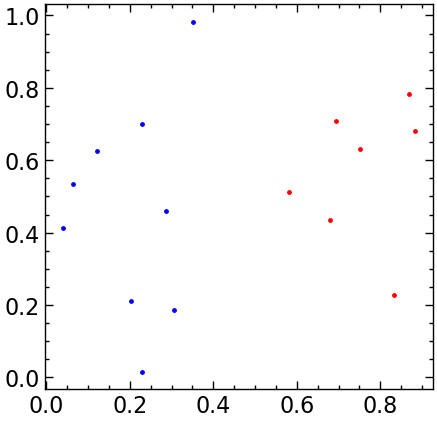

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr], r[1][ixr], color='r', s=6)
plt.scatter(r[0][ixl], r[1][ixl], color='b', s=6)
# here in torch we need to switch to CPU if we want to plot

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.
* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [26]:
v = np.zeros((2, n_particles))
v.shape
# v[0] - the X velocity of all particles
v[0][ixr] = -500  # desni grejo v levo
v[0][ixl] = 500  # levi grejo v desno (it's a mask for the direction)
# every pytorch function is analogous to numpy, really handy


To run this simulation, we need to determine when two particles collid, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are *n* particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [27]:
ids_pairs = np.asarray(list(combinations(ids, 2)))
ids_pairs  # 120 pairs for 16 particles, this is why it gets expensive

array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 0, 15],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 1, 15],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 2, 14],
       [ 2, 15],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 3,  7],
       [ 3,  8],
       [ 3,  9],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 13],
       [ 3, 14],
       [ 3, 15],
       [ 4,  5],
       [ 4,  6],
       [ 4,  7],
       [ 4,  8],
       [ 4,  9

In [28]:
x_pairs = np.asarray(list(combinations(r[0], 2)))
x_pairs

array([[0.8832749 , 0.83180556],
       [0.8832749 , 0.2855218 ],
       [0.8832749 , 0.30466029],
       [0.8832749 , 0.69277974],
       [0.8832749 , 0.7506649 ],
       [0.8832749 , 0.22884157],
       [0.8832749 , 0.35017182],
       [0.8832749 , 0.58039311],
       [0.8832749 , 0.03914189],
       [0.8832749 , 0.06494611],
       [0.8832749 , 0.68069417],
       [0.8832749 , 0.86988494],
       [0.8832749 , 0.22903396],
       [0.8832749 , 0.12063634],
       [0.8832749 , 0.20294438],
       [0.83180556, 0.2855218 ],
       [0.83180556, 0.30466029],
       [0.83180556, 0.69277974],
       [0.83180556, 0.7506649 ],
       [0.83180556, 0.22884157],
       [0.83180556, 0.35017182],
       [0.83180556, 0.58039311],
       [0.83180556, 0.03914189],
       [0.83180556, 0.06494611],
       [0.83180556, 0.68069417],
       [0.83180556, 0.86988494],
       [0.83180556, 0.22903396],
       [0.83180556, 0.12063634],
       [0.83180556, 0.20294438],
       [0.2855218 , 0.30466029],
       [0.

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [29]:
dx_pairs = np.diff(x_pairs, axis=1).ravel()
# gives distance between all pairs v oklepajih, 
#  .ravel() unravels it into a 1D array/tensor
dx_pairs

array([-5.14693408e-02, -5.97753099e-01, -5.78614603e-01, -1.90495153e-01,
       -1.32609993e-01, -6.54433327e-01, -5.33103073e-01, -3.02881790e-01,
       -8.44133005e-01, -8.18328787e-01, -2.02580731e-01, -1.33899604e-02,
       -6.54240938e-01, -7.62638552e-01, -6.80330512e-01, -5.46283758e-01,
       -5.27145262e-01, -1.39025812e-01, -8.11406521e-02, -6.02963986e-01,
       -4.81633732e-01, -2.51412449e-01, -7.92663664e-01, -7.66859446e-01,
       -1.51111390e-01,  3.80793805e-02, -6.02771598e-01, -7.11169212e-01,
       -6.28861171e-01,  1.91384957e-02,  4.07257946e-01,  4.65143106e-01,
       -5.66802282e-02,  6.46500258e-02,  2.94871309e-01, -2.46379906e-01,
       -2.20575688e-01,  3.95172368e-01,  5.84363138e-01, -5.64878397e-02,
       -1.64885454e-01, -8.25774134e-02,  3.88119450e-01,  4.46004610e-01,
       -7.58187239e-02,  4.55115300e-02,  2.75732813e-01, -2.65518402e-01,
       -2.39714184e-01,  3.76033872e-01,  5.65224643e-01, -7.56263354e-02,
       -1.84023949e-01, -

The total distance is just $d_{ij} = \sqrt{\Delta x_{ij}^{2} + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [30]:
x_pairs = np.asarray(list(combinations(r[0], 2)))
y_pairs = np.asarray(list(combinations(r[1], 2)))
dx_pairs = np.diff(x_pairs, axis=1).ravel()
dy_pairs = np.diff(y_pairs, axis=1).ravel()
d_pairs = np.sqrt(dx_pairs**2 + dy_pairs**2)
# these distances correspond to the ids_pairs, we look at these distances
#  at each step of the simulation/iteration
d_pairs

array([0.45553829, 0.6371842 , 0.76005688, 0.19284542, 0.14111831,
       0.93189152, 0.61341425, 0.34575124, 0.88510422, 0.83087336,
       0.31716832, 0.10574473, 0.65452774, 0.76448908, 0.82587993,
       0.59348772, 0.52867731, 0.5022617 , 0.41242256, 0.63875325,
       0.89644048, 0.38069534, 0.81429604, 0.82669362, 0.25756499,
       0.55881378, 0.76558039, 0.81567818, 0.62905455, 0.27284309,
       0.47822808, 0.49606783, 0.44637352, 0.52808542, 0.29976001,
       0.25054699, 0.23357468, 0.395863  , 0.66893307, 0.2466004 ,
       0.23504584, 0.26095854, 0.65116459, 0.6297399 , 0.18667933,
       0.79758372, 0.42703815, 0.34910938, 0.4234    , 0.45089   ,
       0.8226571 , 0.51776739, 0.47663773, 0.10465366, 0.09735351,
       0.83432922, 0.43834123, 0.22660255, 0.71761499, 0.6514593 ,
       0.27432482, 0.19228343, 0.46386787, 0.57815769, 0.69869566,
       0.80668085, 0.5330008 , 0.20744447, 0.74414519, 0.69234744,
       0.20791098, 0.19408564, 0.52599728, 0.63004762, 0.69019

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [31]:
radius = 0.06 # quite large this is bad for gas
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

array([[ 0, 12],
       [ 3, 15],
       [ 4,  5],
       [10, 14]])

In [32]:
v1 = v[:, ids_pairs_collide[:, 0]]
v2 = v[:, ids_pairs_collide[:, 1]]
r1 = r[:, ids_pairs_collide[:, 0]]
r2 = r[:, ids_pairs_collide[:, 1]]

Then we can compute the new velocity:

In [33]:
v1new = v1 - np.sum((v1-v2).T@(r1-r2), axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - np.sum((v1-v2).T@(r1-r2), axis=0)/np.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [34]:
def get_delta_pairs(x):
    return np.diff(np.asarray(list(combinations(x,2))), axis=1).ravel()

def get_deltad_pairs(r):
    return np.sqrt(get_delta_pairs(r[0])**2 + get_delta_pairs((r[1]))**2)

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - np.sum((v1-v2).T@(r1-r2), axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - np.sum((v1-v2).T@(r1-r2), axis=0)/np.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1,ts):
        ic = id_pairs[get_deltad_pairs(r) < d_cutoff]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]],
                                                   r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -np.abs(v[0,r[0]>1])
        v[0,r[0]<0] = np.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -np.abs(v[1,r[1]>1])
        v[1,r[1]<0] = np.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as function of time (3D array `rs` where each axis is $(t, x, y)$).

In [35]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=8e-6, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

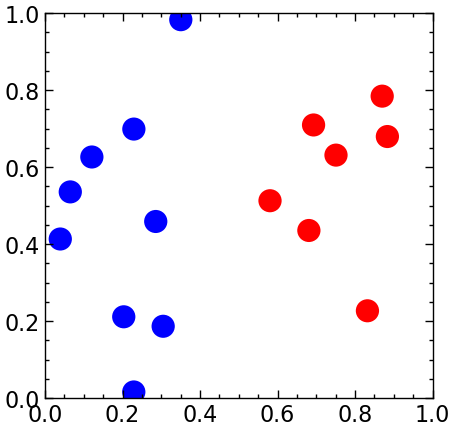

In [37]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl], rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred, yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue, yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

RuntimeError: The animation function must return a sequence of Artist objects.

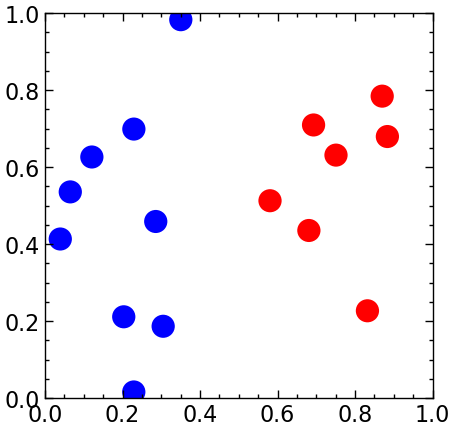

In [39]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

def animate(i):
    ax.clear()
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl], rs[i][1][ixl]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred, yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue, yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4', writer='pillow', dpi=100)

Now that we're sure that it work, lets make a simulation containing many more particles

In [ ]:
n_particles = 16
r = np.random.random((2, n_particles))
ixr = r[0]>0.5
ixl = r[0]<= 0.5
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids, 2)))
v = np.zeros((2, n_particles))
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0015
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=8e-6, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [ ]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

In [ ]:
bins = np.linspace(0, 1500, 50)
plt.figure()
plt.hist(np.sqrt(np.sum(vs[400]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v, fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

def animate(i):
    [ax.clear() for ax in axes]
    ax = axes[0]
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl], rs[i][1][ixl]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred, yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue, yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax = axes[1]
    ax.hist(np.sqrt(np.sum(vs[i]**2, axis=0)), bins=bins, density=True)
    ax.plot(v, fv)
    ax.set_xlabel('Velocity [m/s]')
    ax.set_ylabel('# Particles')
    ax.set_xlim(0, 1500)
    ax.set_ylim(0, 0.006)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    fig.tight_layout()
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4', writer='pillow', dpi=100)